# Canadian Institute for Cybersecurity Intrision detection 2017 dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import copy
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, concatenate
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt

In [2]:
# reading the dataset
directory = 'dataset/MachineLearningCVE'

dfs = []

for filename in os.listdir(directory):
    if filename.endswith('.csv'):  
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)

final_df = pd.concat(dfs, ignore_index=True)


In [3]:
print(final_df.isnull().sum())

 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Length: 79, dtype: int64


In [4]:
#remove leading spaces in the header
final_df.columns = final_df.columns.str.strip()

In [5]:
final_df.shape

(2830743, 79)

In [6]:
final_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,166,1,1,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
1,60148,83,1,2,0,0,0,0,0.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
2,123,99947,1,1,48,48,48,48,48.0,0.0,...,40,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
3,123,37017,1,1,48,48,48,48,48.0,0.0,...,32,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN
4,0,111161336,147,0,0,0,0,0,0.0,0.0,...,0,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,BENIGN


# Data Cleaning

In [7]:
#numeric columns
numeric_columns = final_df.select_dtypes(include=['number']).columns.tolist()
numeric_columns

['Destination Port',
 'Flow Duration',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Total Length of Fwd Packets',
 'Total Length of Bwd Packets',
 'Fwd Packet Length Max',
 'Fwd Packet Length Min',
 'Fwd Packet Length Mean',
 'Fwd Packet Length Std',
 'Bwd Packet Length Max',
 'Bwd Packet Length Min',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Flow Bytes/s',
 'Flow Packets/s',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Total',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'Fwd Header Length',
 'Bwd Header Length',
 'Fwd Packets/s',
 'Bwd Packets/s',
 'Min Packet Length',
 'Max Packet Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'FIN Flag Count',
 'SYN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'UR

In [8]:
# Find columns with infinite or too large values
columns_with_issues = []
for column in numeric_columns:
    if np.any(np.isinf(final_df[column])) or np.any(np.abs(final_df[column]) > np.finfo(np.float64).max):
        columns_with_issues.append(column)

# Display columns with issues
print("Columns with infinite or too large values:", columns_with_issues)

Columns with infinite or too large values: ['Flow Bytes/s', 'Flow Packets/s']


In [9]:
#drop colums with infine values
final_df = final_df.drop(columns=columns_with_issues, axis=1)

In [10]:
# colums with the the same values
same_value_columns = [
    column for column in final_df.columns if final_df[column].nunique() == 1]
same_value_columns

['Bwd PSH Flags',
 'Bwd URG Flags',
 'Fwd Avg Bytes/Bulk',
 'Fwd Avg Packets/Bulk',
 'Fwd Avg Bulk Rate',
 'Bwd Avg Bytes/Bulk',
 'Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate']

In [11]:
#drop colums with the same value 
final_df = final_df.drop(columns=same_value_columns, axis=1)

In [12]:
final_df.shape

(2830743, 69)

# Eploratory data analysis

In [13]:
# encoding the Label as Benign  or or anomaly
def map_Label(label):
    return 'BENIGN' if label == 'BENIGN' else 'Anomaly'


final_df_EDA = final_df.copy()
# Create the new 'Label' feature
final_df_EDA['Label_anomaly'] = final_df_EDA['Label'].apply(map_Label)

final_df_EDA['Label_anomaly'].unique()

array(['BENIGN', 'Anomaly'], dtype=object)

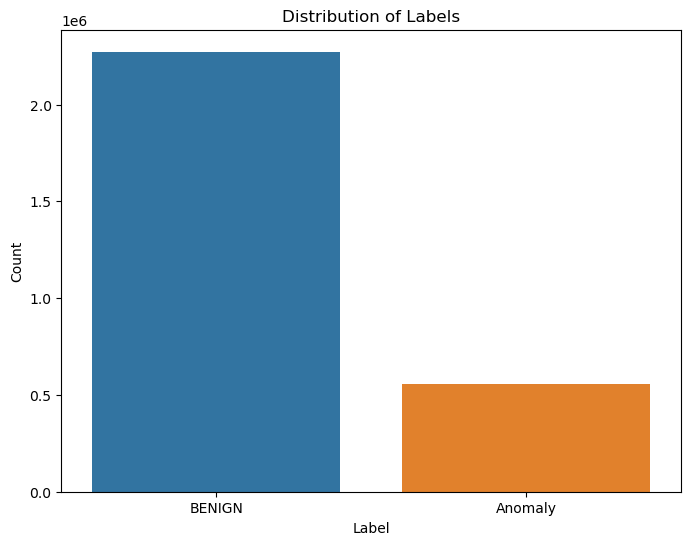

In [14]:
label_counts = final_df_EDA['Label_anomaly'].value_counts()

# Plotting the distribution of labels
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

Rorelation heat MAP

In [15]:
# numeric columns
num_col = final_df_EDA.select_dtypes(include=['number']).columns.tolist()

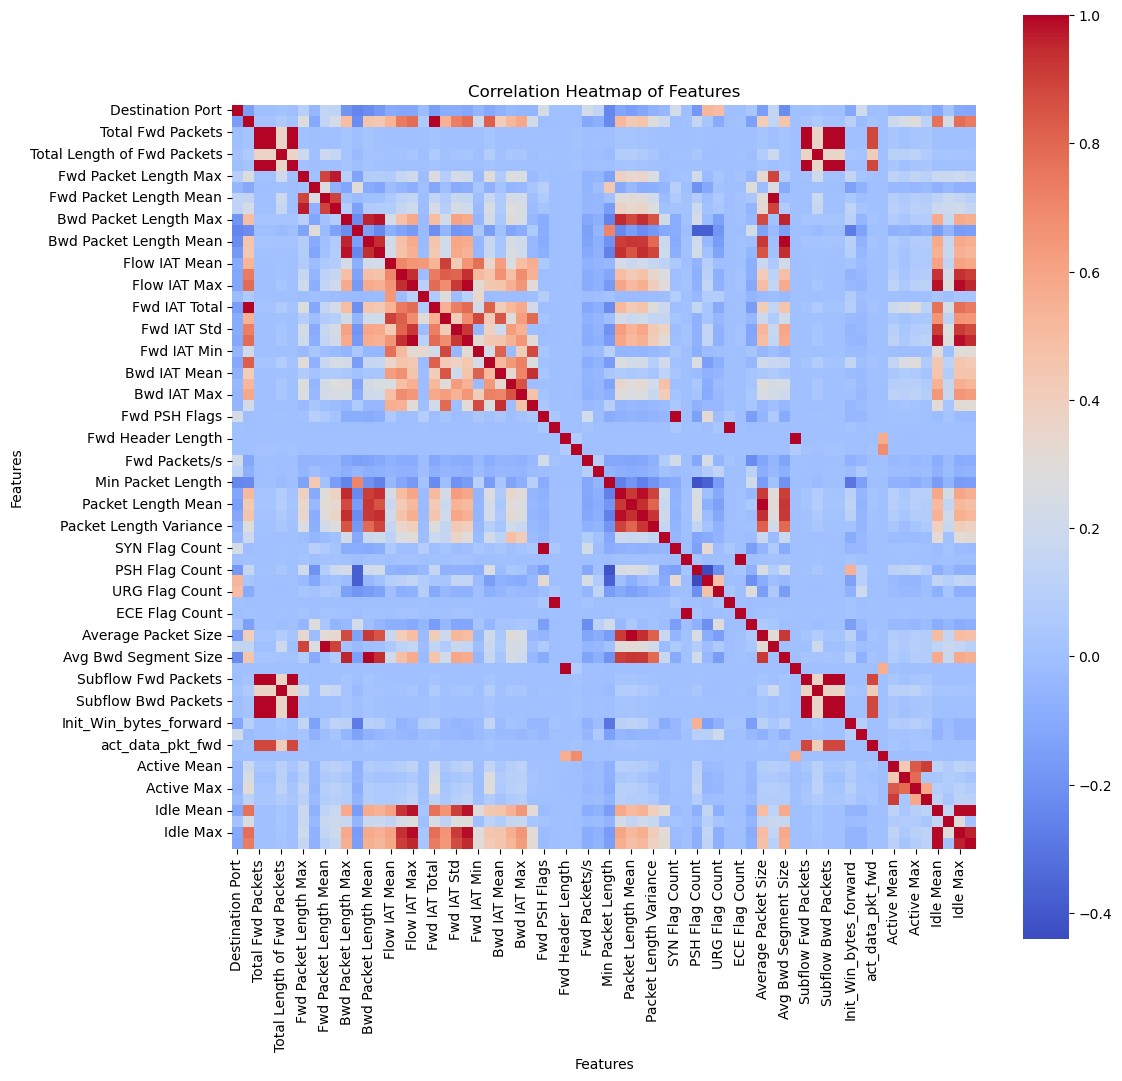

In [16]:
correlation_matrix = final_df_EDA[num_col].corr()


plt.figure(figsize=(12, 12))


sns.heatmap(correlation_matrix, cmap='coolwarm', square=True)

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Correlation Heatmap of Features')

# Rotate x-axis labels for better readability with many features
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show the plot
plt.show()

In [17]:
# Getting and printing high correlated features
limit = 0.9
corr_mat = final_df_EDA[num_col].corr()
columns = corr_mat.columns
for i in range(corr_mat.shape[0]):
    for j in range(i+1, corr_mat.shape[0]):
        if corr_mat.iloc[i, j] >= 0.9:
            print(f"{columns[i]:20s} {columns[j]:20s} {corr_mat.iloc[i, j]}")

Flow Duration        Fwd IAT Total        0.9985599326309608
Total Fwd Packets    Total Backward Packets 0.9990699513710241
Total Fwd Packets    Total Length of Bwd Packets 0.9969928007533168
Total Fwd Packets    Subflow Fwd Packets  1.0
Total Fwd Packets    Subflow Bwd Packets  0.9990699513710241
Total Fwd Packets    Subflow Bwd Bytes    0.9969866573972213
Total Backward Packets Total Length of Bwd Packets 0.9944292856838406
Total Backward Packets Subflow Fwd Packets  0.9990699513710241
Total Backward Packets Subflow Bwd Packets  1.0
Total Backward Packets Subflow Bwd Bytes    0.9944241078555393
Total Length of Fwd Packets Subflow Fwd Bytes    0.9999993580553541
Total Length of Bwd Packets Subflow Fwd Packets  0.9969928007533168
Total Length of Bwd Packets Subflow Bwd Packets  0.9944292856838406
Total Length of Bwd Packets Subflow Bwd Bytes    0.9999998601344989
Fwd Packet Length Max Fwd Packet Length Std 0.9684135845690643
Fwd Packet Length Mean Avg Fwd Segment Size 1.0
Bwd Packet Le

In [18]:
final_df_1m =  final_df_EDA.head(10000)

In [19]:
final_df_1m.shape

(10000, 70)

/Users/felixdelaliadigbli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/felixdelaliadigbli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/felixdelaliadigbli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/felixdelaliadigbli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

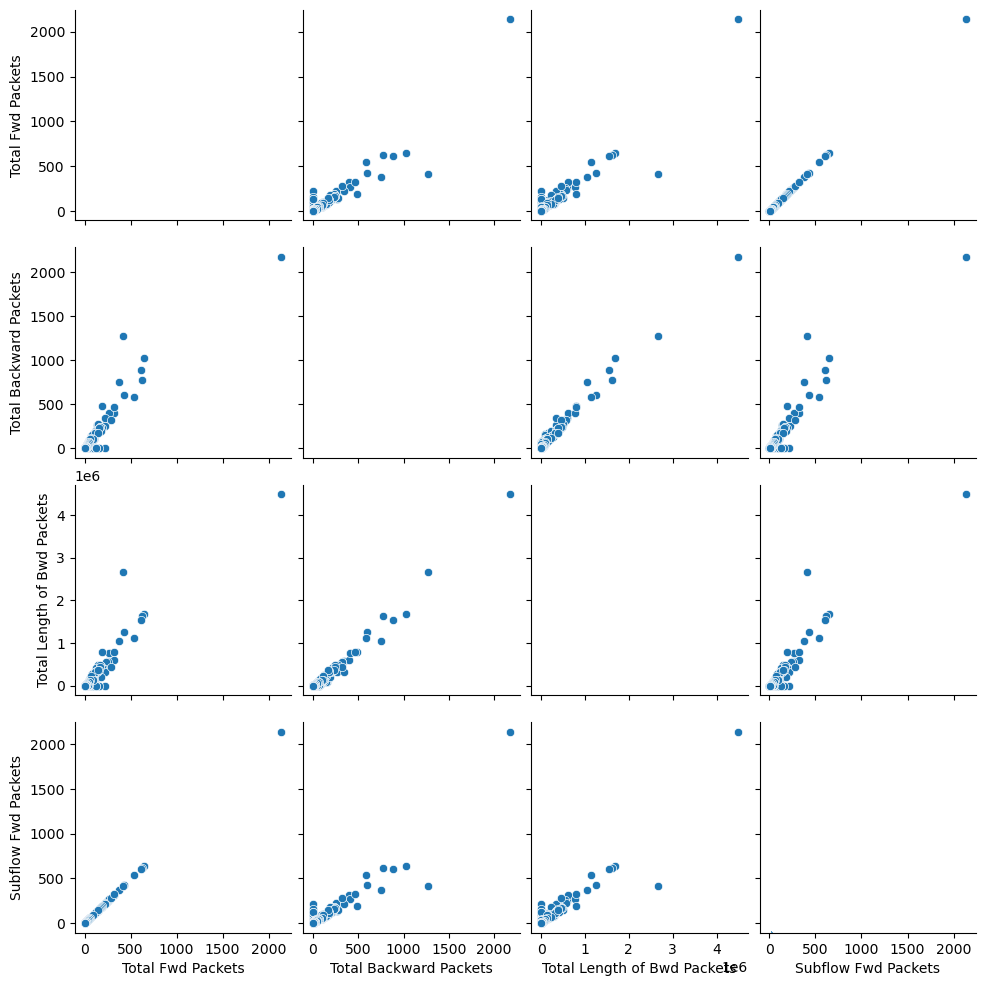

In [20]:
# ct_dst_ltm, ct_src_ltm, ct_src_dport_ltm and ct_dst_sport_ltm
sns.pairplot(final_df_1m, vars=['Total Fwd Packets', 'Total Backward Packets',
             'Total Length of Bwd Packets', 'Subflow Fwd Packets'])
plt.show()

In [21]:
columns_to_scale = final_df.drop('Label', axis=1).columns.tolist()
columns_to_scale

['Destination Port',
 'Flow Duration',
 'Total Fwd Packets',
 'Total Backward Packets',
 'Total Length of Fwd Packets',
 'Total Length of Bwd Packets',
 'Fwd Packet Length Max',
 'Fwd Packet Length Min',
 'Fwd Packet Length Mean',
 'Fwd Packet Length Std',
 'Bwd Packet Length Max',
 'Bwd Packet Length Min',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow IAT Max',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd IAT Mean',
 'Fwd IAT Std',
 'Fwd IAT Max',
 'Fwd IAT Min',
 'Bwd IAT Total',
 'Bwd IAT Mean',
 'Bwd IAT Std',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Fwd PSH Flags',
 'Fwd URG Flags',
 'Fwd Header Length',
 'Bwd Header Length',
 'Fwd Packets/s',
 'Bwd Packets/s',
 'Min Packet Length',
 'Max Packet Length',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'FIN Flag Count',
 'SYN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'URG Flag Count',
 'CWE Flag Count',
 'ECE Flag Count',
 'Down/Up Ratio',
 

In [22]:
for column in final_df.columns:
    print(column)

Destination Port
Flow Duration
Total Fwd Packets
Total Backward Packets
Total Length of Fwd Packets
Total Length of Bwd Packets
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd PSH Flags
Fwd URG Flags
Fwd Header Length
Bwd Header Length
Fwd Packets/s
Bwd Packets/s
Min Packet Length
Max Packet Length
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count
RST Flag Count
PSH Flag Count
ACK Flag Count
URG Flag Count
CWE Flag Count
ECE Flag Count
Down/Up Ratio
Average Packet Size
Avg Fwd Segment Size
Avg Bwd Segment Size
Fwd Header Length.1
Subflow Fwd Packets
Subflow Fwd Bytes
Subflow Bwd Packets
Subflow Bwd Bytes
Init_Win_bytes_forward
Init_Win_byt

In [23]:
# Standardizing the data
scaler = StandardScaler()
scaler = scaler.fit(final_df[columns_to_scale])
final_df[columns_to_scale] = scaler.transform(
    final_df[columns_to_scale])

# save scaler
joblib.dump(scaler, 'scaler.joblib')

final_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,-0.440256,-0.439342,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN
1,2.848259,-0.439344,-0.011153,-0.008416,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN
2,-0.434732,-0.436377,-0.011153,-0.009418,-0.050162,-0.007121,-0.222537,0.485361,-0.054822,-0.245069,...,0.002564,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN
3,-0.434732,-0.438247,-0.011153,-0.009418,-0.050162,-0.007121,-0.222537,0.485361,-0.054822,-0.245069,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN
4,-0.441460,2.863743,0.183599,-0.010421,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,0.002527,2.578171,5.292734,4.552249,-0.100852,0.048540,0.467932,0.201267,-0.095009,BENIGN


In [24]:
for column in final_df.columns:
    print(column)

Destination Port
Flow Duration
Total Fwd Packets
Total Backward Packets
Total Length of Fwd Packets
Total Length of Bwd Packets
Fwd Packet Length Max
Fwd Packet Length Min
Fwd Packet Length Mean
Fwd Packet Length Std
Bwd Packet Length Max
Bwd Packet Length Min
Bwd Packet Length Mean
Bwd Packet Length Std
Flow IAT Mean
Flow IAT Std
Flow IAT Max
Flow IAT Min
Fwd IAT Total
Fwd IAT Mean
Fwd IAT Std
Fwd IAT Max
Fwd IAT Min
Bwd IAT Total
Bwd IAT Mean
Bwd IAT Std
Bwd IAT Max
Bwd IAT Min
Fwd PSH Flags
Fwd URG Flags
Fwd Header Length
Bwd Header Length
Fwd Packets/s
Bwd Packets/s
Min Packet Length
Max Packet Length
Packet Length Mean
Packet Length Std
Packet Length Variance
FIN Flag Count
SYN Flag Count
RST Flag Count
PSH Flag Count
ACK Flag Count
URG Flag Count
CWE Flag Count
ECE Flag Count
Down/Up Ratio
Average Packet Size
Avg Fwd Segment Size
Avg Bwd Segment Size
Fwd Header Length.1
Subflow Fwd Packets
Subflow Fwd Bytes
Subflow Bwd Packets
Subflow Bwd Bytes
Init_Win_bytes_forward
Init_Win_byt

In [25]:
# encoding the Label as 0 or 1
def map_Label(label):
    return 0 if label == 'BENIGN' else 1


# Create the new 'Label' feature
final_df['Label_binary'] = final_df['Label'].apply(map_Label)

final_df['Label_binary'].unique()

array([0, 1])

In [26]:
final_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label_binary
0,-0.440256,-0.439342,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN,0
1,2.848259,-0.439344,-0.011153,-0.008416,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN,0
2,-0.434732,-0.436377,-0.011153,-0.009418,-0.050162,-0.007121,-0.222537,0.485361,-0.054822,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN,0
3,-0.434732,-0.438247,-0.011153,-0.009418,-0.050162,-0.007121,-0.222537,0.485361,-0.054822,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN,0
4,-0.441460,2.863743,0.183599,-0.010421,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,2.578171,5.292734,4.552249,-0.100852,0.048540,0.467932,0.201267,-0.095009,BENIGN,0


# Stage 1

In [27]:
final_df['Label_binary'].value_counts()

Label_binary
0    2273097
1     557646
Name: count, dtype: int64

In [28]:
# function for sequence creation
def create_sequences(features, target, sequence_length):
    sequences = []
    labels = []
    for i in range(len(features) - sequence_length + 1):
        sequence = features.iloc[i:i + sequence_length].values
        label = target[i + sequence_length - 1]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [29]:
# Sequence Generation
# parameter refers to the number of time steps included in each input sequence to the LSTM
sequence_length = 5
features =  final_df.drop(columns=['Label', 'Label_binary'])
target = final_df['Label_binary']
X, y = create_sequences(features, target, sequence_length)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [31]:
# function to create Model

def create_model(sequence_length, num_features):
    # The CNN branch is designed to extract spatial features from each sequence.
    cnn_input = Input(shape=(sequence_length, num_features))
    # this layer specifies that the convolutional layer is one-dimensional,
    cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
    # max-pooling layer is used to reduce dimensionality
    cnn = MaxPooling1D(pool_size=2)(cnn)
    # flattening layer to transform the data into a format suitable for concatenation
    cnn = Flatten()(cnn)

    # LSTM branch
    # The LSTM branch processes the sequences to capture long-term dependencies and temporal patterns
    lstm_input = Input(shape=(sequence_length, num_features))
    lstm = LSTM(64)(lstm_input)

    # Concatenate branches
    merged = concatenate([cnn, lstm])

    # Output layer
    # The Dense layer is a fully connected neural network layer where each input node is connected to each output node
    output = Dense(1, activation='sigmoid')(merged)
    # The activation='sigmoid' argument specifies that a sigmoid activation function is used in this layer and nd outputs a value
    # between 0 and 1, which is suitable for binary classification tasks.

    # Model
    model = Model(inputs=[cnn_input, lstm_input], outputs=output)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  # The loss function, also known as the cost function, measures how well the model performs on the dataset.
                  metrics=['accuracy', Precision(), Recall()])
    # The optimizer is an algorithm or method used to change the attributes of the neural network, such as weights and learning rate, to reduce the losses.
    # adam (Adaptive Moment Estimation)provide an optimization algorithm that can handle sparse gradients on noisy problems.
    return model

In [32]:
# creating model
model = create_model(sequence_length, X_train.shape[2])

In [33]:
# Training Model
model.fit([X_train, X_train], y_train, epochs=10,
          batch_size=64, validation_split=0.1)

Epoch 1/10
27866/27866 [==============================] - 81s 3ms/step - loss: 0.0341 - accuracy: 0.9876 - precision: 0.9678 - recall: 0.9693 - val_loss: 0.0234 - val_accuracy: 0.9916 - val_precision: 0.9764 - val_recall: 0.9810
Epoch 2/10
27866/27866 [==============================] - 64s 2ms/step - loss: 0.0208 - accuracy: 0.9922 - precision: 0.9788 - recall: 0.9818 - val_loss: 0.0217 - val_accuracy: 0.9921 - val_precision: 0.9856 - val_recall: 0.9742
Epoch 3/10
27866/27866 [==============================] - 73s 3ms/step - loss: 0.0182 - accuracy: 0.9933 - precision: 0.9811 - recall: 0.9849 - val_loss: 0.0174 - val_accuracy: 0.9936 - val_precision: 0.9805 - val_recall: 0.9873
Epoch 4/10
27866/27866 [==============================] - 70s 3ms/step - loss: 0.0165 - accuracy: 0.9940 - precision: 0.9829 - recall: 0.9868 - val_loss: 0.0154 - val_accuracy: 0.9945 - val_precision: 0.9838 - val_recall: 0.9886
Epoch 5/10
27866/27866 [==============================] - 72s 3ms/step - loss: 0.013

In [34]:
# Model evaluation
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    [X_test, X_test], y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

26539/26539 [==============================] - 18s 676us/step - loss: 0.0090 - accuracy: 0.9976 - precision: 0.9944 - recall: 0.9933
Test Loss: 0.009013792499899864
Test Accuracy: 0.9975883960723877
Test Precision: 0.9944322109222412
Test Recall: 0.993327260017395


In [35]:
# the predictions of the model on the test data
# Since the model has two inputs, we will need to provide the test data twice
predictions = model.predict([X_test, X_test])

26539/26539 [==============================] - 17s 601us/step


In [36]:
# The predictions will be in the form of probabilities. To convert them to class labels,
# we will use a threshold (e.g., 0.5 for binary classification)
threshold = 0.5
predicted_labels = np.where(predictions > threshold, 1, 0)

In [37]:
#Save stage1 Model
#joblib.dump(model, 'stage1_model.joblib')
model.save('docker/models/stage1_model.h5')

/Users/felixdelaliadigbli/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Stage 2

In [38]:
# Dataset for stage 2 
stage2_data = final_df[final_df['Label'] != 'BENIGN']

In [39]:
stage2_data.shape

(557646, 70)

In [40]:
stage2_data['Label'].value_counts()

Label
DoS Hulk                      231073
PortScan                      158930
DDoS                          128027
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

In [41]:
#creating unknow situation
# Infiltration and Heartbleed are change to unknown.
stage2_data['Label'] = stage2_data['Label'].replace('Infiltration', 'Unknown')
stage2_data['Label'] = stage2_data['Label'].replace('Heartbleed', 'Unknown')
stage2_data['Label'].value_counts()

/var/folders/yz/2pbqqbpn6sj4b27rbp_l9n280000gn/T/ipykernel_88910/449403443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage2_data['Label'] = stage2_data['Label'].replace('Infiltration', 'Unknown')
/var/folders/yz/2pbqqbpn6sj4b27rbp_l9n280000gn/T/ipykernel_88910/449403443.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage2_data['Label'] = stage2_data['Label'].replace('Heartbleed', 'Unknown')


Label
DoS Hulk                      231073
PortScan                      158930
DDoS                          128027
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Unknown                           47
Web Attack � Sql Injection        21
Name: count, dtype: int64

In [42]:
# encode the label



le = LabelEncoder()
stage2_data['Label'] = le.fit_transform(stage2_data['Label'])

# To get the mapping of original values to encoded values
encoded_values = dict(zip(le.classes_, le.transform(le.classes_)))

# Print the mapping
print("Encoded values:")
for key, value in encoded_values.items():
    print(f"{key}: {value}")

Encoded values:
Bot: 0
DDoS: 1
DoS GoldenEye: 2
DoS Hulk: 3
DoS Slowhttptest: 4
DoS slowloris: 5
FTP-Patator: 6
PortScan: 7
SSH-Patator: 8
Unknown: 9
Web Attack � Brute Force: 10
Web Attack � Sql Injection: 11
Web Attack � XSS: 12


/var/folders/yz/2pbqqbpn6sj4b27rbp_l9n280000gn/T/ipykernel_88910/1862555493.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stage2_data['Label'] = le.fit_transform(stage2_data['Label'])


In [43]:
# train test split for stage 2 data
X_stage2 = stage2_data.drop(columns=['Label', 'Label_binary'], axis=1)
y_stage2 = stage2_data['Label']
X_train_stage2, X_test_stage2, y_train_stage2, y_test_stage2 = train_test_split(X_stage2, y_stage2, test_size=0.3, random_state=42)

In [44]:
test_concat = pd.concat([X_test_stage2, y_test_stage2], axis=1)

In [45]:
test_concat.to_csv('dataset/attacks_with_label.csv', index=False)

In [46]:
benign = final_df[final_df['Label'] == 'BENIGN']
benign.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label_binary
0,-0.440256,-0.439342,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN,0
1,2.848259,-0.439344,-0.011153,-0.008416,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN,0
2,-0.434732,-0.436377,-0.011153,-0.009418,-0.050162,-0.007121,-0.222537,0.485361,-0.054822,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN,0
3,-0.434732,-0.438247,-0.011153,-0.009418,-0.050162,-0.007121,-0.222537,0.485361,-0.054822,-0.245069,...,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,BENIGN,0
4,-0.441460,2.863743,0.183599,-0.010421,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,...,2.578171,5.292734,4.552249,-0.100852,0.048540,0.467932,0.201267,-0.095009,BENIGN,0


In [47]:
beningn_data = benign.drop(columns=['Label', 'Label_binary'])
beningn_data = benign.head(50000)
beningn_data.to_csv('dataset/benigndata.csv', index=False)

In [48]:
#fit Random Forest model
Stage2_model = RandomForestClassifier(n_estimators=50, random_state=42)
Stage2_model.fit(X_train_stage2, y_train_stage2)

RandomForestClassifier(n_estimators=50, random_state=42)

In [49]:
#predit attacck type
y_pred = Stage2_model.predict(X_test_stage2)

In [50]:
stage2_accuracy = accuracy_score(y_test_stage2, y_pred)
stage2_precision = precision_score(y_test_stage2, y_pred, average='weighted')
stage2_recall = recall_score(y_test_stage2, y_pred, average='weighted')

print("Test Accuracy:", stage2_accuracy)
print("Test Precision:", stage2_precision)
print("Test Recall:", stage2_recall)

Test Accuracy: 0.9983741198130238
Test Precision: 0.9982314912924847
Test Recall: 0.9983741198130238
